In [1]:
# from . import _distributor_init
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In D:\Anaconda\envs\data_engeneering\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda\envs\data_engeneering\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda\envs\data_engeneering\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda\envs\data_engeneering\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda\envs\data_engeneering\lib\site-packages\m

In [2]:
dangjin_fcst = pd.read_csv('data/preprocessed_dangjin_fcst.csv')
ulsan_fcst = pd.read_csv('data/preprocessed_ulsan_fcst.csv')
energy = pd.read_csv('data/energy.csv')
energy_dangjin = pd.read_csv('data/energy_dangjin(dg).csv')

In [3]:
energy_dangjin.isnull().sum()

Unnamed: 0         0
time               0
dangjin            0
capacity           0
time_generation    0
Forecast_time      0
Temperature        0
Humidity           0
WindSpeed          0
WindDirection      0
Cloud              0
dtype: int64

In [4]:
# df = pd.concat([dangjin_fcst, energy['dangjin']], axis=1)
# df = energy_dangjin.drop(['dangjin', 'capacity', 'time', 'Unnamed: 0'], axis=1)
# df.rename(columns={'time_generation' : 'dangjin'}, inplace=True)

# df = energy_dangjin.drop(['time_generation', 'capacity', 'time', 'Unnamed: 0'], axis=1)

In [5]:
df = pd.concat([dangjin_fcst, energy['dangjin']], axis=1)
df = df.drop(['Unnamed: 0', 'Forecast_time'], axis=1)

In [6]:
df

,Temperature,Humidity,WindSpeed,WindDirection,Cloud,dangjin
0,-2.000000,55.000000,6.7,336.000000,1.0,0.0
1,-2.666667,55.000000,6.3,337.000000,1.0,0.0
2,-3.333333,55.000000,5.9,338.000000,1.0,0.0
3,-4.000000,55.000000,5.5,339.000000,1.0,0.0
4,-4.333333,56.666667,5.1,340.666667,1.0,0.0
...,...,...,...,...,...,...
26299,6.333333,85.000000,6.3,31.666667,4.0,NaN
26300,5.666667,85.000000,6.1,29.333333,4.0,NaN
26301,5.000000,85.000000,5.9,27.000000,4.0,NaN
26302,5.000000,85.000000,5.9,27.000000,4.0,NaN


In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df) - 672
train_df = df[0:int(n*0.7)] # 70%를 학습 데이터로 사용
val_df = df[int(n*0.7):23064] # 학습용 70%와 28일을 제외한 데이터를 검증 데이터로 사용
test_df = df[23064:-672] # 에너지 발생 데이터가 없는 28일을 테스트용 데이터로 사용

pred_df = df[-672:]

# n = len(df)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
pred_df = (pred_df - train_mean) / train_std

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, pred_df=pred_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.pred_df = pred_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [10]:
w1 = WindowGenerator(input_width=24, label_width=24, shift=1,   # input_width = 24 -> 24시간이 주어졌을 때, label_width = 24 -> 24시간 예측, shift = 24 -> 미래의 24시간을 예측하도록 함
                     label_columns=['dangjin'])
w1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['dangjin']

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 6)
Inputs shape: (3, 24, 6)
labels shape: (3, 24, 1)


In [13]:
w1.example = example_inputs, example_labels

In [14]:
def plot(self, model=None, plot_col='dangjin', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

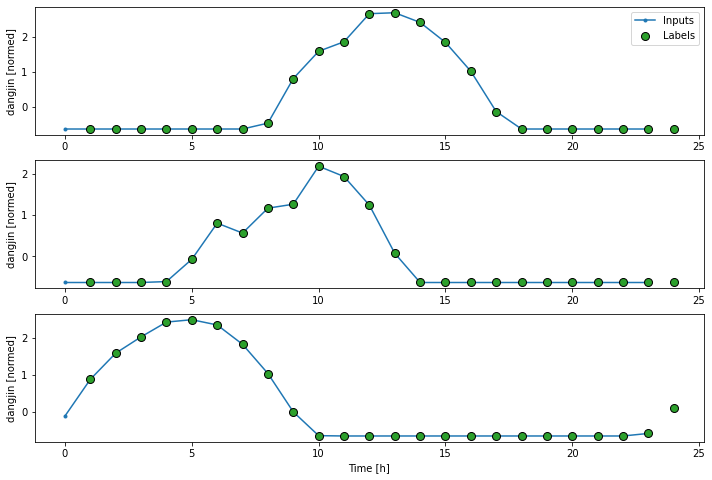

In [15]:
w1.plot()

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def pred(self):
    return self.make_dataset(self.pred_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.pred = pred



In [18]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 24, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [19]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 6)
Labels shape (batch, time, features): (32, 24, 1)


In [20]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['dangjin'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['dangjin']

In [21]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [22]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [23]:
baseline = Baseline(label_index=column_indices['dangjin'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

161/161 [==============================] - 0s 1ms/step - loss: 0.1619 - mean_absolute_error: 0.2313


In [24]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=24,
    label_columns=['dangjin'])

wide_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['dangjin']

In [25]:
print("window train : ", wide_window.train)
print("window val : ", wide_window.val)
print("window test : ", wide_window.test)
print("window example : ", wide_window.example)
print("window pred : ", wide_window.pred)

window train :  <MapDataset shapes: ((None, 24, 6), (None, 24, 1)), types: (tf.float32, tf.float32)>
window val :  <MapDataset shapes: ((None, 24, 6), (None, 24, 1)), types: (tf.float32, tf.float32)>
window test :  <MapDataset shapes: ((None, 24, 6), (None, 24, 1)), types: (tf.float32, tf.float32)>
window example :  (<tf.Tensor: shape=(32, 24, 6), dtype=float32, numpy=
array([[[ 0.7991333 , -0.34184495, -0.8475214 , -1.1044612 ,
         -1.2820425 ,  0.3998954 ],
        [ 0.9695857 , -0.54839784, -0.9230098 , -1.0531708 ,
         -1.2820425 ,  1.2638843 ],
        [ 1.1059477 , -0.9615037 , -0.9355912 , -1.3064167 ,
         -1.2820425 ,  1.8777711 ],
        ...,
        [ 0.49231893,  1.3105783 , -1.0488238 ,  0.5175949 ,
         -0.6874577 , -0.6368913 ],
        [ 0.45822844,  1.3105783 , -1.0739866 ,  0.42783687,
         -1.2820425 , -0.6368913 ],
        [ 0.66277134,  0.79419607, -1.023661  ,  0.37654656,
         -1.2820425 , -0.51866126]],

       [[ 0.7991333 ,  1.000749

In [26]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


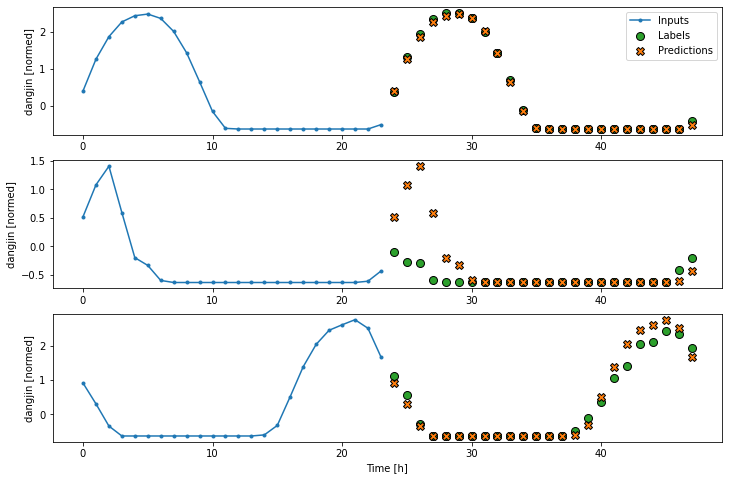

In [27]:
wide_window.plot(baseline)

In [28]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [29]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


In [30]:
MAX_EPOCHS = 1
print("window train : ", wide_window.train)
print("window val : ", wide_window.val)
print("window pred : ", wide_window.pred)

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    return history

window train :  <MapDataset shapes: ((None, 24, 6), (None, 24, 1)), types: (tf.float32, tf.float32)>
window val :  <MapDataset shapes: ((None, 24, 6), (None, 24, 1)), types: (tf.float32, tf.float32)>
window pred :  <MapDataset shapes: ((None, 24, 6), (None, 24, 1)), types: (tf.float32, tf.float32)>


In [31]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

159/159 [==============================] - 1s 5ms/step - loss: 0.2226 - mean_absolute_error: 0.2901


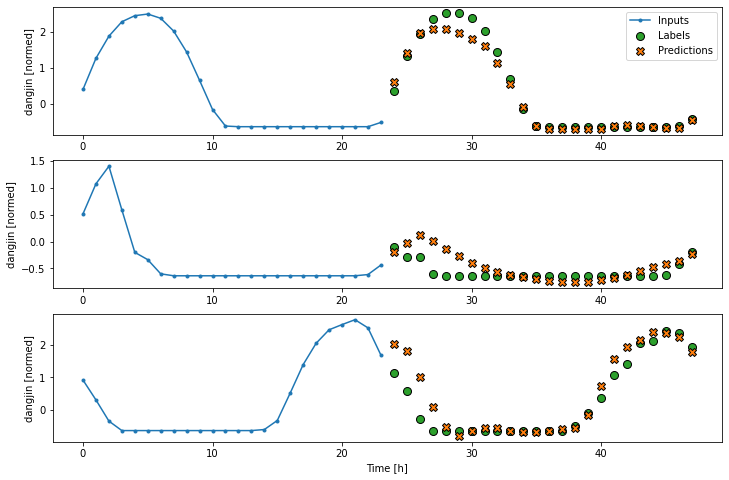

In [32]:
wide_window.plot(lstm_model)

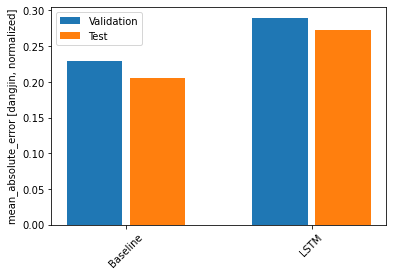

In [33]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [dangjin, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [39]:
predictions = lstm_model.predict(wide_window.train)
# wide_window.example[0]

In [37]:
predictions

array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]], dtype=float32)

In [42]:
predictions[5:10]

array([[[-0.3348304 ],
        [-0.5221492 ],
        [-0.6028776 ],
        [-0.6160245 ],
        [-0.5999801 ],
        [-0.57487273],
        [-0.3953528 ],
        [ 0.08261216],
        [ 0.7152186 ],
        [ 1.4197451 ],
        [ 1.8833746 ],
        [ 2.1893349 ],
        [ 2.1722193 ],
        [ 2.10962   ],
        [ 1.9155052 ],
        [ 1.4817709 ],
        [ 0.77220833],
        [-0.08509975],
        [-0.5908799 ],
        [-0.65394795],
        [-0.6607124 ],
        [-0.650644  ],
        [-0.6638398 ],
        [-0.68209535]],

       [[ 0.5614377 ],
        [ 0.4107497 ],
        [ 0.06754678],
        [-0.2656483 ],
        [-0.50038916],
        [-0.57577693],
        [-0.57121193],
        [-0.54170644],
        [-0.49484414],
        [-0.4590553 ],
        [-0.43594265],
        [-0.50556296],
        [-0.59237707],
        [-0.6685673 ],
        [-0.49910006],
        [-0.17386279],
        [ 0.47653672],
        [ 1.1264745 ],
        [ 1.5173101 ],
        [